<a href="https://colab.research.google.com/github/Divyesh-Kanagavel/deep_learning--keras/blob/master/convnetvisual.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [33]:
from tensorflow.keras.applications import VGG16
from keras import backend as K



In [34]:
model = VGG16(weights ='imagenet', include_top = False)


In [35]:
import tensorflow as tf
tf.compat.v1.disable_eager_execution()
import numpy as np

def deprocess_image(x):
  x-=x.mean()
  x/=(x.std()+1e-5)
  x*=0.1
  x+=0.5
  x = np.clip(x,0,1)

  x*=255
  x = np.clip(x,0,255).astype('uint8')
  return x

  


  
  


In [36]:
def generate_pattern(layer_name, filter_index,size=150):
  layer_output = model.get_layer(layer_name).output
  loss = K.mean(layer_output[:,:,:,filter_index])
  grads = K.gradients(loss,model.input)[0]
  grads/= (K.sqrt(K.mean(K.square(grads)))+1e-5)

  iterate = K.function([model.input], [loss,grads])

  input_img_data = np.random.random((1,size,size,3))*20 + 128.

  step=1
  for i in range(40):
    loss_value, grads_value = iterate([input_img_data])
    input_img_data+=step*grads_value


  img = input_img_data[0]
  return deprocess_image(img)


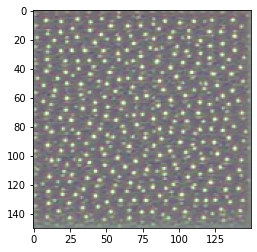

In [37]:
import matplotlib.pyplot as plt
plt.imshow(generate_pattern('block3_conv1',0))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


<Figure size 1440x1440 with 0 Axes>

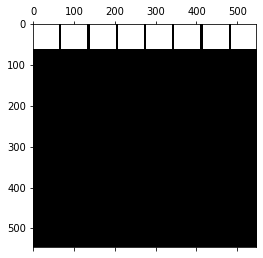

<Figure size 1440x1440 with 0 Axes>

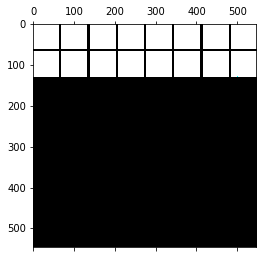

<Figure size 1440x1440 with 0 Axes>

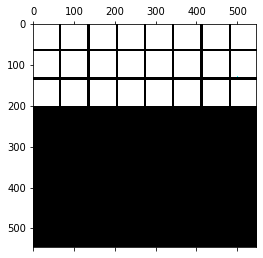

<Figure size 1440x1440 with 0 Axes>

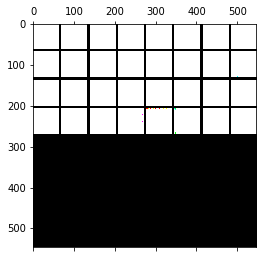

<Figure size 1440x1440 with 0 Axes>

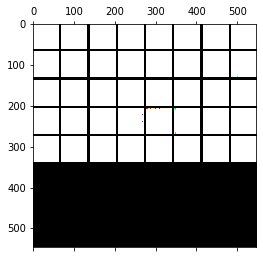

<Figure size 1440x1440 with 0 Axes>

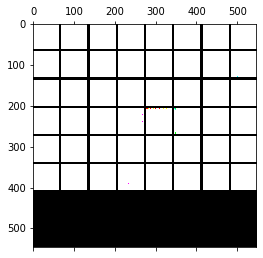

<Figure size 1440x1440 with 0 Axes>

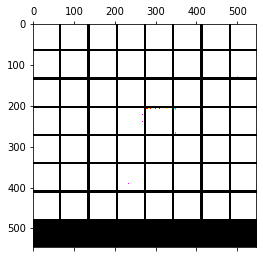

<Figure size 1440x1440 with 0 Axes>

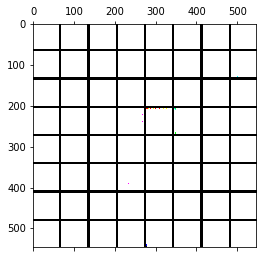

In [38]:
layer_name = 'block2_conv1'
size = 64
margin = 5

results = np.zeros((8*size+7*margin,8*size+7*margin,3))

for i in range(8):
  for j in range(8):
    filter_img = generate_pattern(layer_name, i+(j*8), size=size)
    hor_start = i*size+i*margin
    hor_end = hor_start+size
    ver_start = j*size+j*margin
    ver_end = ver_start+size

    results[hor_start:hor_end,ver_start:ver_end,:] = filter_img


  plt.figure(figsize=(20,20))
  plt.matshow(results)




In [39]:
from tensorflow.keras.applications.vgg16 import VGG16
model = VGG16(weights='imagenet')



In [40]:
from keras.preprocessing import image
from keras.applications.vgg16 import preprocess_input, decode_predictions
import numpy as np
img_path = '/content/elephant.jpg'
img = image.load_img(img_path, target_size = (224,224))
x = image.img_to_array(img)
x = np.expand_dims(x,axis=0)
x = preprocess_input(x)


In [41]:
preds = model.predict(x)
print("Predicted: ",decode_predictions(preds, top=3)[0])

/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:2470: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


Predicted:  [('n02504458', 'African_elephant', 0.8451774), ('n01871265', 'tusker', 0.14580026), ('n02504013', 'Indian_elephant', 0.008667638)]


In [42]:
np.argmax(preds[0])

386

In [53]:
african_elephant_output = model.output[:,386]
last_conv_layer =model.get_layer('block5_conv3')


<tf.Tensor 'block5_conv3_1/Relu:0' shape=(None, 14, 14, 512) dtype=float32>

In [60]:

grads = K.gradients(african_elephant_output,last_conv_layer.output)[0]

In [61]:

pooled_grads = K.mean(grads,axis=(0,1,2))


In [62]:

iterate_s = K.function([model.input],[pooled_grads, last_conv_layer.output[0]])



pooled_grads,conv_layer_output_value = iterate_s([x])
for i in range(512):
  conv_layer_output_value[:,:,i] *= pooled_grads[i]

heatmap = np.mean(conv_layer_output_value,axis=-1)


(14, 14)

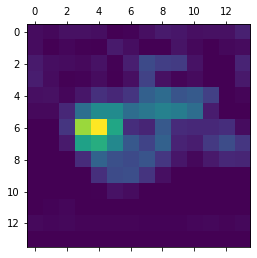

In [63]:
#Visualizing heat map

#normalizing the heatmap

heatmap = np.maximum(heatmap,0)
heatmap/=np.max(heatmap)
plt.matshow(heatmap)

In [66]:
import cv2
img = cv2.imread(img_path)
heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
heatmap = np.uint8(255*heatmap)
heatmap= cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
superimposed_img = heatmap*0.5+img
cv2.imwrite('/content/elephant_cam.jpg', superimposed_img)


True